In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn import preprocessing
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
#from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score,mean_squared_error,max_error,mean_absolute_percentage_error
from sklearn import preprocessing
import plotly.graph_objects as go
#%matplotlib auto

import warnings
warnings.filterwarnings('ignore')

In [3]:
# def apply_windowing(X, y, idx, n_window):
#     dataX = X[idx:idx + WINDOW * n_window]  # prendo 5 valori alla volta

#     dataX = dataX.reshape((n_window, WINDOW, dataX.shape[1]))
#     dataY = y[idx:idx + WINDOW * n_window]
#     dataY = dataY.reshape((n_window, WINDOW, dataY.shape[1]))  # #rows/5, 5, #columns
#     print('Windowing applied')
#     return dataX, dataY

# def apply_inverse_windowing(X, y, n_window):
#     dataX = X.reshape((n_window * WINDOW, X.shape[2]))
#     dataY = y.reshape((n_window * WINDOW, y.shape[2]))
#     print('Inverse windowing applied')
#     return dataX, dataY

def add_dimension_1(x):
    if x.ndim == 1:
        return x.reshape((x.shape[0], 1))
    else:
        return x
#  
def apply_scaler(train_X, train_y):
    
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(np.concatenate((train_X, train_y), axis=1))
    print('Scaler built')
    X_shape = train_X.shape
    y_shape = train_y.shape
    tmp = scaler.transform(np.concatenate((train_X, train_y), axis=1))    
    print('Scaler applied')
    return tmp[:, :X_shape[1]], tmp[:, X_shape[1]:]

def apply_inverse_scaler(train_Xo, train_yo, train_X, train_y):
    
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(np.concatenate((train_Xo, train_yo), axis=1))
    print('Scaler built')
    X_shape = train_X.shape
    y_shape = train_y.shape
    #tmp = scaler.transform(np.concatenate((train_X, train_y), axis=1))   
    tmp = scaler.inverse_transform(np.concatenate((train_X, train_y), axis=1)) 
    print('Scaler applied')
    return tmp[:, :X_shape[1]], tmp[:, X_shape[1]:]

In [7]:
def create_model(layer_lstm_sizes = 0, 
                 lstm_activation = 'tanh',
                 layer_dense_size = 3,
                 lstm_neurons = 32, 
                 dense_neurons = 32, 
                 penalty = 0.01, #0.00001,
                 huber_delta = 1,
                 undersampled = False, #True,
                 window_size = 1,
                 shuffle = True,
                 learning_rate=0.0001,
                 rr=0.0001,
                 br=0.0001
                ):
    
    #model = tf.keras.Sequential()
    model = Sequential()
    # input layer
    model.add(LSTM(lstm_neurons, input_shape=input_shape, 
                kernel_regularizer= regularizers.l1_l2(penalty),
                recurrent_regularizer=keras.regularizers.l2(rr),
                bias_regularizer=keras.regularizers.l2(br),
                activation= lstm_activation,
                return_sequences=False #True
                     ))
#     # more hidden
#     for layer_number in range(layer_lstm_sizes):
#         model.add(LSTM(lstm_neurons, return_sequences=True, 
#                 kernel_regularizer= regularizers.l1_l2(penalty),
#                 activation= lstm_activation
#                      ))
#     # last hidden to stretch lstm over time
#     model.add(LSTM(lstm_neurons, return_sequences= False, 
#                 #kernel_regularizer= regularizers.l1_l2(penalty), #flattens too much the curve?
#                 activation= lstm_activation
#                      ))
    for layer in range(layer_dense_size):
        model.add(Dense(dense_neurons, 
                               #kernel_regularizer= regularizers.l1_l2(penalty), #flattens too much the curve?
                               activation='relu'))
        
    model.add(Dense(output_shape))
    
    opt = keras.optimizers.Adam(learning_rate=learning_rate) # default 0.001
    #loss = 'mean_squared_error' #keras.losses.Huber(delta=huber_delta)
    loss = keras.losses.Huber(delta=huber_delta)
    model.compile(loss=loss, optimizer=opt,
             metrics=[tf.keras.metrics.MeanSquaredError()] # necessary, if we add regularization it will be included in loss
             ) 
    return model

In [8]:
def apply_model_predict(model, X, y):  # re-align y_predict shape to y shape
    predict_y = model.predict(X)
    print('Model has been applied to predict signal')
    #predict_y = predict_y.reshape(y.shape)
    return predict_y

def metric(reco, true):
    import numpy as np
    #print('len true: ', len(true))
    #print('len reco: ', len(reco))
    thr= 0.78 * np.percentile(np.array(true),95)
    rel_diff = np.array([abs(np.array(t)-np.array(r))/t for t,r in zip(true, reco) if t>thr])
    mymin = np.percentile(rel_diff,1)
    mymax = np.percentile(rel_diff,99)
    out = [x for x in rel_diff if (x > mymin and x < mymax)]
    d = np.average(out)*100
    diff = np.array([abs(np.array(t)-np.array(r)) for t,r in zip(true, reco) if t>thr])
    p50 = np.percentile(diff, 50)
    p90 = np.percentile(diff, 90)
    #print(p90)
    
    # voglio trovare x tc np.percentile(diff, x)=20°C
    min_perc = 0.
    max_perc = 100.01
    step = 0.01
    y = np.arange(min_perc, max_perc, step)
    perc = [np.percentile(diff, _x) for _x in y]
    smaller_20 = perc < 20*np.ones(len(y))
    x_20 = y[np.argmin(smaller_20)]
    smaller_10 = perc < 10*np.ones(len(y))
    x_10 = y[np.argmin(smaller_10)]
    
    # want to understand which is the average/median discrepancy of the latest 10% of the distribution
    sorted_diff = np.sort(diff) # dal più piccolo al più grande
    latest_x_10 = sorted_diff[int(x_10/100*len(diff)):] # ultimo x% dei dati
    mean_over = np.mean(latest_x_10)
    median_over = np.median(latest_x_10)
    #print('metric function executed once')
    print('largest value in the distribution: ', diff.max())
    return round(d,1), round(p50,1), round(p90,1), round(x_10,2), round(mean_over, 1), round(median_over, 1)

In [6]:
lstm_neurons=32
dense_neurons = 32
penalty=0 #0.01
layer_lstm_sizes=0
layer_dense_size=3
lstm_activation='relu' #'tanh'
learning_rate=0.0005
epochs=5000
rr=0 #0.0001
br=0 #0.0001

MyListVec = [] #list()

MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,32,penalty,1,True,1,True,learning_rate,epochs,rr,br]
MyListVec.append(list(MyList))

# # MyList=[1,2,1]
# # MyListVec.append(list(MyList))
# # print(MyListVec)

# for lstm_neurons in [16,32,64,128]:
#     for penalty in [0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]: 
#         for layer_lstm_sizes in[1,2,3,4]:
#             for layer_dense_size in[0,1,2,4,5]: 
#                 for lstm_activation in ['relu']:

#                     MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,32,penalty,1,True,1,True]
#                     MyListVec.append(list(MyList))

# for learning_rate in [0.0001, 0.001, 0.01]:
#     MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,32,penalty,1,True,1,True,learning_rate]
#     MyListVec.append(list(MyList))  

# MyListVec = [] #list()
# for epochs in [500]: #, 600, 700, 800, 900, 1000]:
#     for penalty in [0.0001, 0.001, 0.01]: #,0.01,0.005,0.001,0.0005,0.0001]: 
#         for rr in [0.0001, 0.001, 0.01]: 
#             for br in [0.0001, 0.001, 0.01]:  
#                 MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,dense_neurons,penalty,1,True,1,True,learning_rate,epochs,rr,br]
#                 MyListVec.append(list(MyList)) 

[0, 'relu', 3, 32, 32, 0, 1, True, 1, True, 0.0005, 5000, 0, 0]
(63116, 12)
['Pin [kPa]', 'Tin [K]', 'N [rpm]', 'Differential Pressure [kPa]', 'Total Consumed power', 'phi', 'Surge Distance', 'GVFin', 'Qin [m3/s]', 'GVFout', 'Qv_out [m3/s]', 'Surge Distance Eq']
Scaler built
Scaler applied
42077
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4864      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)    

1/1 [==============================] - 0s 5ms/step - loss: 0.2018 - mean_squared_error: 0.3202
Epoch 137/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.1986 - mean_squared_error: 0.3137
Epoch 138/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.1954 - mean_squared_error: 0.3073
Epoch 139/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.1923 - mean_squared_error: 0.3011
Epoch 140/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.1893 - mean_squared_error: 0.2950
Epoch 141/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.1864 - mean_squared_error: 0.2891
Epoch 142/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.1836 - mean_squared_error: 0.2834
Epoch 143/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.1808 - mean_squared_error: 0.2778
Epoch 144/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.1781 - mean_squared_error: 0.2724
Epoch 145/5000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 0.0654 - mean_squared_error: 0.0832
Epoch 285/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0652 - mean_squared_error: 0.0829
Epoch 286/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0649 - mean_squared_error: 0.0825
Epoch 287/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0647 - mean_squared_error: 0.0822
Epoch 288/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0644 - mean_squared_error: 0.0819
Epoch 289/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0641 - mean_squared_error: 0.0816
Epoch 290/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0639 - mean_squared_error: 0.0813
Epoch 291/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0636 - mean_squared_error: 0.0810
Epoch 292/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0634 - mean_squared_error: 0.0807
Epoch 293/5000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 0.0403 - mean_squared_error: 0.0528
Epoch 433/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0402 - mean_squared_error: 0.0527
Epoch 434/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0401 - mean_squared_error: 0.0526
Epoch 435/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0401 - mean_squared_error: 0.0526
Epoch 436/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0400 - mean_squared_error: 0.0525
Epoch 437/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0399 - mean_squared_error: 0.0524
Epoch 438/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0398 - mean_squared_error: 0.0522
Epoch 439/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0396 - mean_squared_error: 0.0519
Epoch 440/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0394 - mean_squared_error: 0.0516
Epoch 441/5000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 0.0293 - mean_squared_error: 0.0381
Epoch 581/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0293 - mean_squared_error: 0.0380
Epoch 582/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0293 - mean_squared_error: 0.0380
Epoch 583/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0292 - mean_squared_error: 0.0380
Epoch 584/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0292 - mean_squared_error: 0.0379
Epoch 585/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0292 - mean_squared_error: 0.0379
Epoch 586/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0292 - mean_squared_error: 0.0380
Epoch 587/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0292 - mean_squared_error: 0.0380
Epoch 588/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0292 - mean_squared_error: 0.0380
Epoch 589/5000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 0.0248 - mean_squared_error: 0.0318
Epoch 729/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0248 - mean_squared_error: 0.0317
Epoch 730/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0247 - mean_squared_error: 0.0317
Epoch 731/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0247 - mean_squared_error: 0.0317
Epoch 732/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0247 - mean_squared_error: 0.0316
Epoch 733/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0247 - mean_squared_error: 0.0316
Epoch 734/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0246 - mean_squared_error: 0.0316
Epoch 735/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0246 - mean_squared_error: 0.0315
Epoch 736/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0246 - mean_squared_error: 0.0315
Epoch 737/5000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 0.0220 - mean_squared_error: 0.0279
Epoch 877/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0218 - mean_squared_error: 0.0275
Epoch 878/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0219 - mean_squared_error: 0.0277
Epoch 879/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0221 - mean_squared_error: 0.0281
Epoch 880/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0221 - mean_squared_error: 0.0280
Epoch 881/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0219 - mean_squared_error: 0.0277
Epoch 882/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0217 - mean_squared_error: 0.0274
Epoch 883/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0218 - mean_squared_error: 0.0276
Epoch 884/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0219 - mean_squared_error: 0.0278
Epoch 885/5000
1/1 [=====

1/1 [==============================] - 0s 5ms/step - loss: 0.0199 - mean_squared_error: 0.0248
Epoch 1025/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0199 - mean_squared_error: 0.0248
Epoch 1026/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0199 - mean_squared_error: 0.0248
Epoch 1027/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0248
Epoch 1028/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0248
Epoch 1029/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0248
Epoch 1030/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0248
Epoch 1031/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0247
Epoch 1032/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0247
Epoch 1033/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0185 - mean_squared_error: 0.0230
Epoch 1171/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0185 - mean_squared_error: 0.0232
Epoch 1172/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0187 - mean_squared_error: 0.0235
Epoch 1173/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0188 - mean_squared_error: 0.0238
Epoch 1174/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0188 - mean_squared_error: 0.0237
Epoch 1175/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0186 - mean_squared_error: 0.0234
Epoch 1176/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0185 - mean_squared_error: 0.0231
Epoch 1177/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0184 - mean_squared_error: 0.0230
Epoch 1178/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0185 - mean_squared_error: 0.0231
Epoch 1179/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0218
Epoch 1317/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0217
Epoch 1318/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0217
Epoch 1319/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0217
Epoch 1320/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0217
Epoch 1321/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0174 - mean_squared_error: 0.0217
Epoch 1322/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0174 - mean_squared_error: 0.0217
Epoch 1323/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0217
Epoch 1324/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0174 - mean_squared_error: 0.0217
Epoch 1325/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0166 - mean_squared_error: 0.0207
Epoch 1463/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0166 - mean_squared_error: 0.0207
Epoch 1464/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0166 - mean_squared_error: 0.0207
Epoch 1465/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0166 - mean_squared_error: 0.0207
Epoch 1466/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0166 - mean_squared_error: 0.0207
Epoch 1467/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0165 - mean_squared_error: 0.0207
Epoch 1468/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0165 - mean_squared_error: 0.0207
Epoch 1469/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0165 - mean_squared_error: 0.0207
Epoch 1470/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0165 - mean_squared_error: 0.0207
Epoch 1471/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0169 - mean_squared_error: 0.0220
Epoch 1609/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0168 - mean_squared_error: 0.0219
Epoch 1610/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0166 - mean_squared_error: 0.0214
Epoch 1611/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0162 - mean_squared_error: 0.0206
Epoch 1612/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0159 - mean_squared_error: 0.0201
Epoch 1613/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0158 - mean_squared_error: 0.0199
Epoch 1614/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0160 - mean_squared_error: 0.0201
Epoch 1615/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0161 - mean_squared_error: 0.0205
Epoch 1616/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0163 - mean_squared_error: 0.0207
Epoch 1617/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0153 - mean_squared_error: 0.0192
Epoch 1755/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153 - mean_squared_error: 0.0192
Epoch 1756/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0192
Epoch 1757/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0192
Epoch 1758/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0192
Epoch 1759/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0192
Epoch 1760/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0192
Epoch 1761/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0192
Epoch 1762/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0192
Epoch 1763/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_squared_error: 0.0187
Epoch 1901/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_squared_error: 0.0186
Epoch 1902/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_squared_error: 0.0186
Epoch 1903/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_squared_error: 0.0187
Epoch 1904/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0148 - mean_squared_error: 0.0187
Epoch 1905/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0148 - mean_squared_error: 0.0187
Epoch 1906/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0148 - mean_squared_error: 0.0187
Epoch 1907/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_squared_error: 0.0187
Epoch 1908/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0147 - mean_squared_error: 0.0186
Epoch 1909/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2047/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2048/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2049/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2050/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2051/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2052/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2053/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2054/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_squared_error: 0.0181
Epoch 2055/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0139 - mean_squared_error: 0.0178
Epoch 2193/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0139 - mean_squared_error: 0.0177
Epoch 2194/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0138 - mean_squared_error: 0.0177
Epoch 2195/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0177
Epoch 2196/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0176
Epoch 2197/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0176
Epoch 2198/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0176
Epoch 2199/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0177
Epoch 2200/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0177
Epoch 2201/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0135 - mean_squared_error: 0.0173
Epoch 2339/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0134 - mean_squared_error: 0.0172
Epoch 2340/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0134 - mean_squared_error: 0.0172
Epoch 2341/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0134 - mean_squared_error: 0.0172
Epoch 2342/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0134 - mean_squared_error: 0.0173
Epoch 2343/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0135 - mean_squared_error: 0.0173
Epoch 2344/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0135 - mean_squared_error: 0.0173
Epoch 2345/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0135 - mean_squared_error: 0.0173
Epoch 2346/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0135 - mean_squared_error: 0.0173
Epoch 2347/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0135 - mean_squared_error: 0.0177
Epoch 2485/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0137 - mean_squared_error: 0.0180
Epoch 2486/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0183
Epoch 2487/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0140 - mean_squared_error: 0.0186
Epoch 2488/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0141 - mean_squared_error: 0.0188
Epoch 2489/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0140 - mean_squared_error: 0.0187
Epoch 2490/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138 - mean_squared_error: 0.0184
Epoch 2491/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0136 - mean_squared_error: 0.0178
Epoch 2492/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0133 - mean_squared_error: 0.0173
Epoch 2493/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.0165
Epoch 2631/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.0165
Epoch 2632/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.0165
Epoch 2633/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.0165
Epoch 2634/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.0165
Epoch 2635/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.0165
Epoch 2636/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.0165
Epoch 2637/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0127 - mean_squared_error: 0.0165
Epoch 2638/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0127 - mean_squared_error: 0.0165
Epoch 2639/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0127 - mean_squared_error: 0.0167
Epoch 2777/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0127 - mean_squared_error: 0.0166
Epoch 2778/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0126 - mean_squared_error: 0.0165
Epoch 2779/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0126 - mean_squared_error: 0.0164
Epoch 2780/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125 - mean_squared_error: 0.0163
Epoch 2781/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125 - mean_squared_error: 0.0162
Epoch 2782/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125 - mean_squared_error: 0.0162
Epoch 2783/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125 - mean_squared_error: 0.0162
Epoch 2784/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125 - mean_squared_error: 0.0163
Epoch 2785/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0123 - mean_squared_error: 0.0161
Epoch 2923/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0122 - mean_squared_error: 0.0160
Epoch 2924/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0122 - mean_squared_error: 0.0159
Epoch 2925/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0122 - mean_squared_error: 0.0159
Epoch 2926/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0122 - mean_squared_error: 0.0159
Epoch 2927/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0122 - mean_squared_error: 0.0160
Epoch 2928/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0122 - mean_squared_error: 0.0160
Epoch 2929/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0122 - mean_squared_error: 0.0160
Epoch 2930/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0123 - mean_squared_error: 0.0160
Epoch 2931/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0119 - mean_squared_error: 0.0157
Epoch 3069/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0119 - mean_squared_error: 0.0157
Epoch 3070/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0119 - mean_squared_error: 0.0157
Epoch 3071/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0157
Epoch 3072/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0120 - mean_squared_error: 0.0157
Epoch 3073/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0157
Epoch 3074/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0157
Epoch 3075/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0120 - mean_squared_error: 0.0157
Epoch 3076/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0157
Epoch 3077/5000
1

1/1 [==============================] - 0s 6ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3215/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3216/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3217/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3218/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3219/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3220/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3221/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3222/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0154
Epoch 3223/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0129 - mean_squared_error: 0.0181
Epoch 3361/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.0178
Epoch 3362/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125 - mean_squared_error: 0.0171
Epoch 3363/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0162
Epoch 3364/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0116 - mean_squared_error: 0.0155
Epoch 3365/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0115 - mean_squared_error: 0.0152
Epoch 3366/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0116 - mean_squared_error: 0.0154
Epoch 3367/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0118 - mean_squared_error: 0.0158
Epoch 3368/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120 - mean_squared_error: 0.0162
Epoch 3369/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0113 - mean_squared_error: 0.0151
Epoch 3507/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0113 - mean_squared_error: 0.0151
Epoch 3508/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0113 - mean_squared_error: 0.0151
Epoch 3509/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0113 - mean_squared_error: 0.0151
Epoch 3510/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114 - mean_squared_error: 0.0151
Epoch 3511/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0114 - mean_squared_error: 0.0151
Epoch 3512/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114 - mean_squared_error: 0.0151
Epoch 3513/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0114 - mean_squared_error: 0.0151
Epoch 3514/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114 - mean_squared_error: 0.0152
Epoch 3515/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0121 - mean_squared_error: 0.0168
Epoch 3653/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0121 - mean_squared_error: 0.0167
Epoch 3654/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0119 - mean_squared_error: 0.0164
Epoch 3655/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0159
Epoch 3656/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114 - mean_squared_error: 0.0154
Epoch 3657/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0112 - mean_squared_error: 0.0150
Epoch 3658/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0111 - mean_squared_error: 0.0148
Epoch 3659/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0112 - mean_squared_error: 0.0149
Epoch 3660/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0113 - mean_squared_error: 0.0151
Epoch 3661/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0111 - mean_squared_error: 0.0150
Epoch 3799/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0111 - mean_squared_error: 0.0149
Epoch 3800/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110 - mean_squared_error: 0.0148
Epoch 3801/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110 - mean_squared_error: 0.0147
Epoch 3802/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0110 - mean_squared_error: 0.0147
Epoch 3803/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110 - mean_squared_error: 0.0146
Epoch 3804/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0109 - mean_squared_error: 0.0146
Epoch 3805/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110 - mean_squared_error: 0.0147
Epoch 3806/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110 - mean_squared_error: 0.0147
Epoch 3807/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0109 - mean_squared_error: 0.0147
Epoch 3945/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0109 - mean_squared_error: 0.0147
Epoch 3946/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0109 - mean_squared_error: 0.0147
Epoch 3947/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0109 - mean_squared_error: 0.0148
Epoch 3948/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0109 - mean_squared_error: 0.0148
Epoch 3949/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0109 - mean_squared_error: 0.0148
Epoch 3950/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0109 - mean_squared_error: 0.0148
Epoch 3951/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0109 - mean_squared_error: 0.0148
Epoch 3952/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110 - mean_squared_error: 0.0148
Epoch 3953/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4091/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4092/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4093/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4094/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4095/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4096/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4097/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4098/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0146
Epoch 4099/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0105 - mean_squared_error: 0.0143
Epoch 4237/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105 - mean_squared_error: 0.0142
Epoch 4238/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105 - mean_squared_error: 0.0142
Epoch 4239/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105 - mean_squared_error: 0.0143
Epoch 4240/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105 - mean_squared_error: 0.0143
Epoch 4241/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0106 - mean_squared_error: 0.0143
Epoch 4242/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0106 - mean_squared_error: 0.0144
Epoch 4243/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0106 - mean_squared_error: 0.0144
Epoch 4244/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105 - mean_squared_error: 0.0143
Epoch 4245/5000
1

1/1 [==============================] - 0s 6ms/step - loss: 0.0107 - mean_squared_error: 0.0147
Epoch 4383/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_error: 0.0150
Epoch 4384/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110 - mean_squared_error: 0.0154
Epoch 4385/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114 - mean_squared_error: 0.0161
Epoch 4386/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0169
Epoch 4387/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0122 - mean_squared_error: 0.0177
Epoch 4388/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0124 - mean_squared_error: 0.0182
Epoch 4389/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0124 - mean_squared_error: 0.0182
Epoch 4390/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0119 - mean_squared_error: 0.0172
Epoch 4391/5000
1

1/1 [==============================] - 0s 6ms/step - loss: 0.0103 - mean_squared_error: 0.0141
Epoch 4529/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0140
Epoch 4530/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0140
Epoch 4531/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0140
Epoch 4532/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0140
Epoch 4533/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0140
Epoch 4534/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0141
Epoch 4535/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0103 - mean_squared_error: 0.0141
Epoch 4536/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0141
Epoch 4537/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0142
Epoch 4675/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0140
Epoch 4676/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0139
Epoch 4677/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0101 - mean_squared_error: 0.0139
Epoch 4678/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0101 - mean_squared_error: 0.0139
Epoch 4679/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0139
Epoch 4680/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0140
Epoch 4681/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0141
Epoch 4682/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0141
Epoch 4683/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4821/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4822/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4823/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4824/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4825/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4826/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4827/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4828/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0138
Epoch 4829/5000
1

1/1 [==============================] - 0s 5ms/step - loss: 0.0105 - mean_squared_error: 0.0148
Epoch 4967/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0103 - mean_squared_error: 0.0144
Epoch 4968/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0101 - mean_squared_error: 0.0140
Epoch 4969/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099 - mean_squared_error: 0.0137
Epoch 4970/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099 - mean_squared_error: 0.0137
Epoch 4971/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0139
Epoch 4972/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0101 - mean_squared_error: 0.0141
Epoch 4973/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0142
Epoch 4974/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0142
Epoch 4975/5000
1

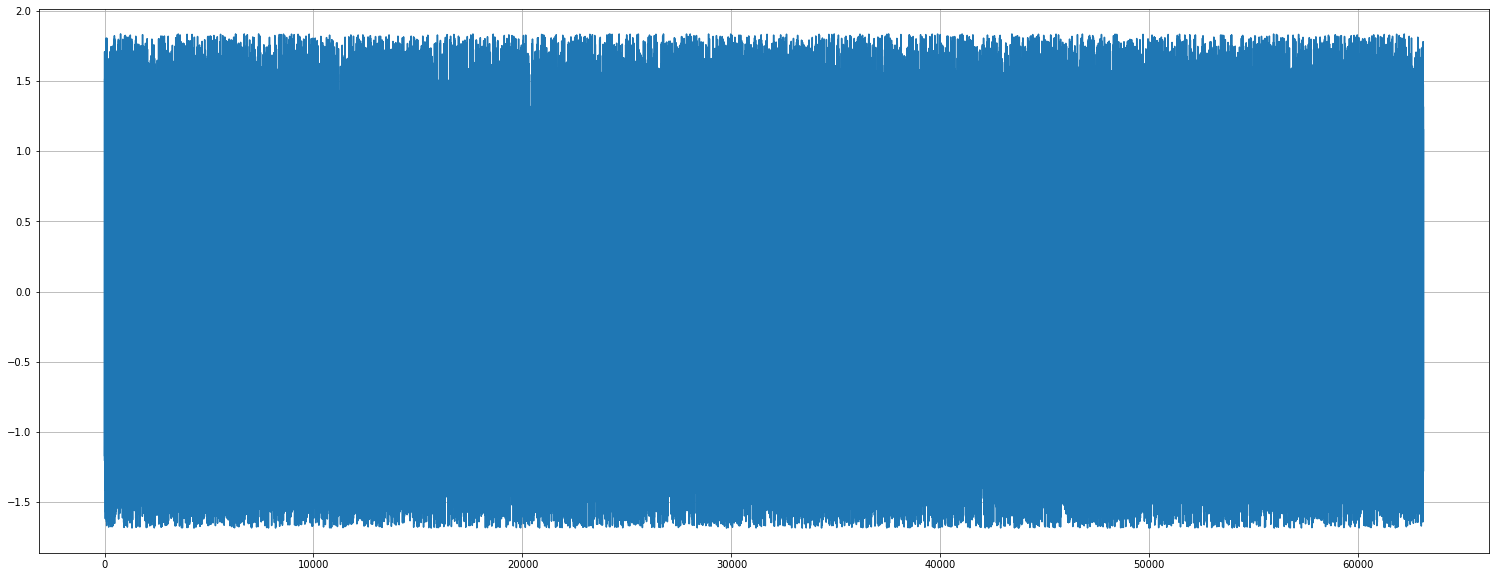

In [30]:
for MyList in MyListVec:
    print(MyList)
    os.system('mkdir test2')
    
    # #data_file = '../PEM1_clean.csv'
    # data_file = '../PEM_Clean2.csv'
    # #data_file = 'PEM2_Clean2.csv'
    # df = pd.read_csv(data_file, sep=',')
    #df=pd.read_pickle('DataL2_Full.pkl')
    file_name = '/data/MGP/TestPointsN2_CH4_H2O_000.xlsx'
    df=pd.read_excel(file_name,header=1).dropna(how='all', axis=1)
    df.drop('#',axis=1,inplace=True)
    #df = pd.read_pickle('../Local/L360.pkl')
    #df=df[df['BRNDMD']>39]
    #df = df.reset_index()
    train_model=1
    columns=['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power','phi',
         'Surge Distance','GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]']
    inputs = ['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power']
    outputs = ['GVFin','GVFout','Qin [m3/s]','Qv_out [m3/s]','phi','Surge Distance','surge_distance_from_eq']
    data=df[columns]
    #df['Diff_Pressure'] = df['Pout [kPA]'] - df['Pin [kPa]']
    phi_surge=0.076
    data['Surge Distance Eq'] = 100*(data['phi']-phi_surge)/phi_surge 
    #df=df[df['Surge Distance Eq']>0]
    

    
    print(data.shape)

    ldf=len(data)

    all_tags=list(data.columns)
    print(all_tags)
    
    x_tags= inputs
    y_tag ='Surge Distance Eq' #['GVFin','Qin _m3/s_'] #,'Hp _kJ/kg_','GVFout','Qv_out _m3/s_','phi','Surge Distance']

    
    X = data[x_tags].values
    y = data[y_tag].values

    X = add_dimension_1(X)
    y = add_dimension_1(y)

    Xo=X;yo=y
    X, y = apply_scaler(X, y)

    X=np.expand_dims(X,axis = 1)
    #y=np.expand_dims(y,axis = y.ndim)

    #plt.plot(X)
    plt.figure(1,figsize=(26,10))
    plt.plot(y)
    plt.grid(True)

    ns=int(ldf*2/3) 
    X_train=X[:ns][:];X_test=X[ns:-1][:];
    y_train=y[:ns];y_test=y[ns:-1];

#     il faudrait train, val, test
#     ns1=int(ldf*1/2) ;ns2=int(ldf*3/4)
#     X_train=X[:ns1][:];X_test=X[ns1:ns2][:];
#     y_train=y[:ns1];y_test=y[ns1:ns2];    


    idx=0
    #train_X, train_y = apply_windowing(X, y, idx, n_window)
    #display(train_y)

    train_X = X_train
    train_y = y_train
    test_X = X_test
    test_y = y_test


    input_shape = (train_X.shape[1], train_X.shape[2])
    output_shape = train_y.shape[1] 
    
    batch_size = int(float(train_X.shape[0])); print(batch_size)    

    
    #MyList=[layer_lstm_sizes,lstm_activation,layer_dense_size,lstm_neurons,32,penalty,1,True,1,True]
    #print(MyList)
    
    with open('MyList.txt', 'w') as f:
        f.write(str(MyList))

    model = create_model(layer_lstm_sizes = MyList[0], # in any case, 2 layers are present
                     lstm_activation = MyList[1], #'tanh',
                     layer_dense_size = MyList[2],  # actually x dense layer before output layer
                     lstm_neurons = MyList[3], 
                     dense_neurons = MyList[4], 
                     penalty = MyList[5],
                     huber_delta = MyList[6],
                     undersampled = MyList[7], # for csv tracking
                     window_size = MyList[8], #5, # for csv tracking
                     shuffle = MyList[9],
                     learning_rate=MyList[10],
                     rr=MyList[12],
                     br=MyList[13]) # try also without

    model.summary()
    
    start = time.time()

    history = model.fit(train_X, train_y, 
                        shuffle=True, 
                        epochs=MyList[11], batch_size=batch_size, #128,
                        verbose=1)

    stop = time.time()
    delta_time = stop-start

    print('Model has been fit in ', delta_time, 'seconds')
    
    
    # Saving Model to json files #
    # -------------------------- #
    import json

    json_filename= 'test2/MyModel.json'
    weights_filename = 'test2/MyWeights.h5'

    model_json = model.to_json()   # questo permette il recupero del modello passando da GPU a CPU  --> sostituirlo in training
    with open(json_filename, 'w') as json_file:
        json.dump(model_json, json_file)

    model.save_weights(weights_filename)  # questo permette il recupero del modello passando da GPU a CPU --> sostituirlo in training

    print('Model json and weights have been saved')
    #---
    
    train_X.shape, train_y.shape
    old_model=model

    predict_y = apply_model_predict(old_model, train_X, train_y)
    predict_y_test = apply_model_predict(old_model, test_X, test_y)

    predict_y_full = apply_model_predict(old_model, X, y)

    X = X[:,0,:]
    X, predict_y_full = apply_inverse_scaler(Xo, yo, X, predict_y_full)

    ns=int(ldf*2/3) 
    predict_y_train2=predict_y_full[:ns];predict_y_test2=predict_y_full[ns:-1];
    y_train2=yo[:ns];y_test2=yo[ns:-1];

    # Evaluation de la qualité du fit
    from sklearn import metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # print('RMSE train: %.3f, test: %.3f' % (np.sqrt(metrics.mean_squared_error(y_train2, predict_y_train2)),
    #                                         np.sqrt(metrics.mean_squared_error(y_test2, predict_y_test2))))

    train_rmse = np.sqrt(metrics.mean_squared_error(y_train2, predict_y_train2)) 
    test_rmse = np.sqrt(metrics.mean_squared_error(y_test2, predict_y_test2))

    print('RMSE train: %.3f, test: %.3f' % (train_rmse,test_rmse))

    train_rmedse = np.sqrt(np.median((np.square(y_train2 - predict_y_train2)))) #.median(axis=0))
    test_rmedse = np.sqrt(np.median((np.square(y_test2 - predict_y_test2)))) #.median(axis=0))

    print('RMedSE train: %.3f, test: %.3f' % (train_rmedse,test_rmedse))

    print('MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train2, predict_y_train2),
                                            mean_absolute_error(y_test2, predict_y_test2)))

    with open('test2/MyScore1.txt', 'w') as f:
        f.write('RMSE train: %.3f, test: %.3f' % (train_rmse,test_rmse))
        f.write('\n')
        f.write('RMedSE train: %.3f, test: %.3f' % (train_rmedse,test_rmedse))
        f.write('\n')
        f.write('MAE train: %.3f, test: %.3f' % (mean_absolute_error(y_train2, predict_y_train2),
                                            mean_absolute_error(y_test2, predict_y_test2)))

    with open('test2/MyScore0.txt', 'w') as f:
        f.write('%.3f\t%.3f\t%.3f' % (test_rmse,test_rmedse,mean_absolute_error(y_test2, predict_y_test2)))   

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index,y=yo[:,0],name=y_tag,mode="lines"))
    fig.add_trace(go.Scatter(y=predict_y_full[:,0],name='predict_y',mode="lines"))
    #fig.add_trace(go.Scatter(x=df.index[7001:],y=predict_y_test[:,0],name='predict_y_test',mode="lines"))

    fig.update_layout(title="Double click on 1 legend to hide or show all the curves, Zoom only x axis by going only left or right")
    fig.write_html('test2/df_y_pred.html', auto_open=False)
    #fig.show()

    #my_ss_metric = metric(ss_pred_y, ss_y)
    my_ss_metric = metric(predict_y, y)

    print('Metric over steady state points (avg discrepancy, p50, p90, px=10): ', my_ss_metric[:4]) #comparer à 0.017

    my_ss_metric

    with open('test2/MyScore2.txt', 'w') as f:
        #f.write('\n')
        f.write(str(my_ss_metric))

    #MyDir=str(MyList[0])+'_'+str(MyList[1])+'_'+str(MyList[2])+'_'+str(MyList[3])+'_'+str(MyList[4])+'_'+str(MyList[5])+'_'+str(MyList[6])+'_'+str(MyList[7])+'_'+str(MyList[8])+'_'+str(MyList[9])+'_'+str(MyList[10])

    #Creating the directory name with all the parameters
    MyDir=''
    for i in range(len(MyList)):
        MyDir=MyDir+str(MyList[i])+'_'
    MyDir=MyDir[:-1] #removing the last _

    os.system('mv test2 '+MyDir)

(0.0, 100.0)

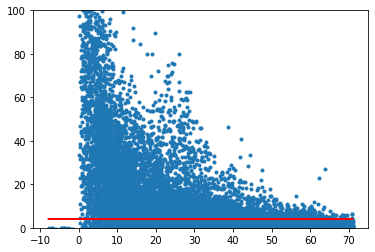

In [31]:
out='Surge Distance Eq'
plt.plot(y_test2,abs(y_test2-predict_y_test2)/y_test2*100,'.')
plt.plot(y_test2,4*np.ones(len(y_test2)),'r')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
plt.ylim(0,100)

In [32]:
data.shape

(63116, 12)

In [33]:
datam = data.copy()
print(datam.shape)
#datam = data.iloc[ns:-1,:]

(63116, 12)


In [34]:
datam = datam.iloc[ns:-1,:]
datam.shape

(21038, 12)

In [35]:
datam['Surge Distance Eq_pred'] = predict_y_test2

In [36]:
import math
output_c2=['Surge Distance Eq']
for i, out in enumerate(output_c2):
    print(f'RMSE_test set_{out}', math.sqrt(mean_squared_error(datam[out],datam[out+'_pred'])))
    print(f'R2 Score_test set_xgb_{out}', r2_score(datam[out],datam[out+'_pred']))
#     print('________________________________\n')

RMSE_test set_Surge Distance Eq 2.7217221758156525
R2 Score_test set_xgb_Surge Distance Eq 0.985273249196509


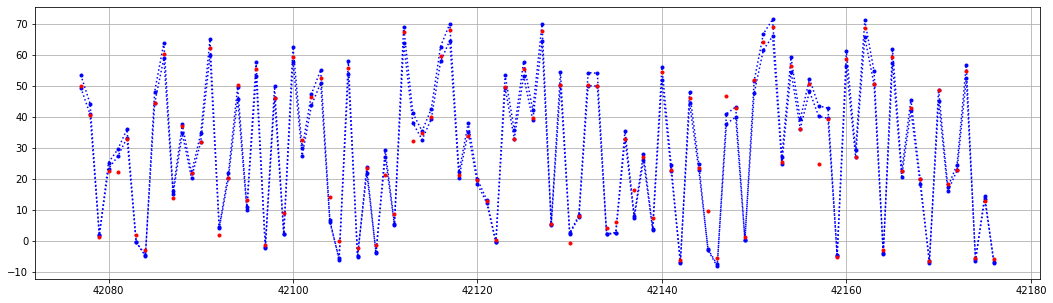

In [37]:
out='Surge Distance Eq'
fig = plt.figure(figsize=(18,5))
plt.plot(datam.head(100)[out]*1.04,'b.:')
plt.plot(datam.head(100)[out]*0.96,'b.:')
plt.plot(datam.head(100)[out+'_pred'],'r.')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
#plt.ylim(0,50)
plt.grid(True)

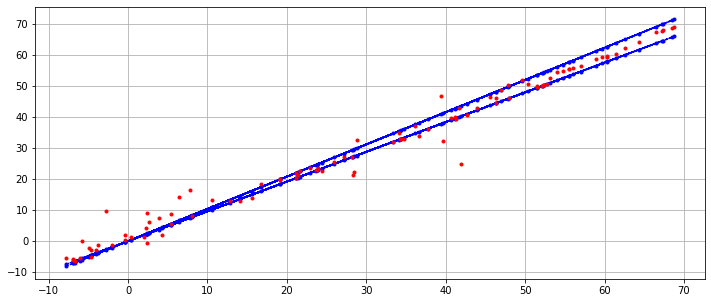

In [39]:
out='Surge Distance Eq'
fig = plt.figure(figsize=(12,5))
plt.plot(datam.head(100)[out],datam.head(100)[out]*1.04,'b.:')
plt.plot(datam.head(100)[out],datam.head(100)[out]*0.96,'b.:')
plt.plot(datam.head(100)[out],datam.head(100)[out+'_pred'],'r.')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
#plt.ylim(0,50)
plt.grid(True)

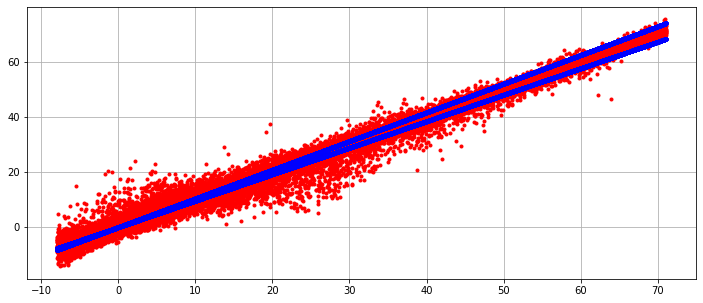

In [40]:
out='Surge Distance Eq'
fig = plt.figure(figsize=(12,5))
plt.plot(datam[out],datam[out+'_pred'],'r.')
plt.plot(datam[out],datam[out]*1.04,'b.:')
plt.plot(datam[out],datam[out]*0.96,'b.:')
#plt.plot(y_test2,-4*np.ones(len(y_test2)),'r')
#plt.ylim(0,50)
plt.grid(True)

In [41]:
out='Surge Distance Eq'
datam['ErrSDpc']=abs(datam[out]-datam[out+'_pred'])/datam[out]*100

In [42]:
ds=datam['ErrSDpc'][datam['ErrSDpc']<4]

In [43]:
len(ds)/len(datam)

0.578619640650252

(array([  9.,  34.,  69., 165., 346., 480., 585., 547., 496., 442., 435.,
        490., 595., 596., 641., 597., 603., 497., 472., 477., 495., 494.,
        490., 472., 402., 447., 499., 505., 508., 487., 446., 449., 417.,
        464., 502., 532., 455., 434., 424., 411., 497., 491., 424., 388.,
        448., 382., 287., 166.,  42.,   4.]),
 array([-14.2149979 , -12.42474302, -10.63448814,  -8.84423326,
         -7.05397838,  -5.2637235 ,  -3.47346862,  -1.68321374,
          0.10704114,   1.89729602,   3.6875509 ,   5.47780578,
          7.26806066,   9.05831554,  10.84857042,  12.6388253 ,
         14.42908018,  16.21933506,  18.00958994,  19.79984482,
         21.5900997 ,  23.38035458,  25.17060946,  26.96086434,
         28.75111922,  30.5413741 ,  32.33162899,  34.12188387,
         35.91213875,  37.70239363,  39.49264851,  41.28290339,
         43.07315827,  44.86341315,  46.65366803,  48.44392291,
         50.23417779,  52.02443267,  53.81468755,  55.60494243,
         57.395197

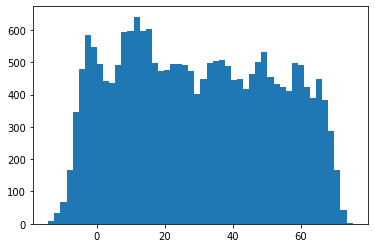

In [45]:
plt.hist(datam['Surge Distance Eq_pred'],bins=50)

In [50]:
hist[data['surge_distance_from_eq']]


(array([1367., 1375., 1361., 1407., 1373., 1365., 1349., 1337., 1341.,
        1313., 1335., 1317., 1369., 1364., 1336., 1327., 1335., 1305.,
        1297., 1322., 1308., 1306., 1286., 1269., 1280., 1315., 1267.,
        1322., 1320., 1289., 1278., 1298., 1265., 1238., 1209., 1244.,
        1253., 1231., 1185., 1207., 1171., 1180., 1153., 1143., 1127.,
        1108., 1078., 1047.,  979.,  865.]),
 array([-7.89396621e+00, -6.31506965e+00, -4.73617309e+00, -3.15727653e+00,
        -1.57837998e+00,  5.16583505e-04,  1.57941314e+00,  3.15830970e+00,
         4.73720626e+00,  6.31610282e+00,  7.89499938e+00,  9.47389594e+00,
         1.10527925e+01,  1.26316891e+01,  1.42105856e+01,  1.57894822e+01,
         1.73683787e+01,  1.89472753e+01,  2.05261719e+01,  2.21050684e+01,
         2.36839650e+01,  2.52628615e+01,  2.68417581e+01,  2.84206546e+01,
         2.99995512e+01,  3.15784478e+01,  3.31573443e+01,  3.47362409e+01,
         3.63151374e+01,  3.78940340e+01,  3.94729306e+01,  4.105182

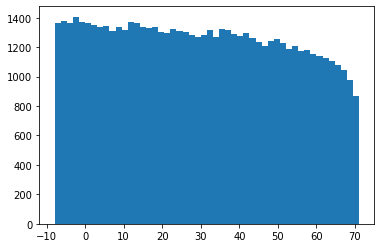

In [52]:
plt.hist(data['Surge Distance Eq'],bins=50)

In [53]:
residuals=datam[out]-datam[out+'_pred']

(array([3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 8.000e+00, 2.000e+00, 6.000e+00, 7.000e+00, 1.400e+01,
        2.300e+01, 1.800e+01, 3.100e+01, 3.100e+01, 4.900e+01, 7.400e+01,
        1.320e+02, 1.960e+02, 3.730e+02, 5.960e+02, 1.099e+03, 1.915e+03,
        3.127e+03, 4.014e+03, 3.674e+03, 2.316e+03, 1.348e+03, 7.080e+02,
        3.850e+02, 2.410e+02, 1.490e+02, 1.240e+02, 8.600e+01, 5.700e+01,
        5.400e+01, 3.400e+01, 3.100e+01, 2.400e+01, 2.200e+01, 1.300e+01,
        1.500e+01, 9.000e+00, 7.000e+00, 6.000e+00, 6.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([-21.80956637, -20.9593262 , -20.10908602, -19.25884584,
        -18.40860567, -17.55836549, -16.70812532, -15.85788514,
        -15.00764496, -14.15740479, -13.30716461, -12.45692443,
        -11.60668426, -10.75644408,  -9.90620391,  -9.05596373,
         -8.20572355,  -7.35548338,  -6.5052432 ,  -5.65500303,
         -4.80476285,  -3.95452267,  -3.1042825 ,  -2.25

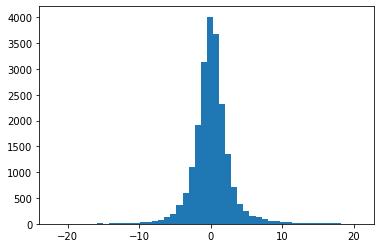

In [54]:
plt.hist(residuals,bins=50)

In [55]:
print(residuals.mean(),residuals.std())

0.08926164937751148 2.7203227220572503


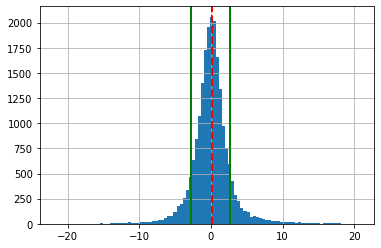

In [59]:
mean = residuals.mean()
std  = residuals.std()


residuals.hist(bins=100)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
plt.axvline(std, color='g', linewidth=2)
plt.axvline(-std, color='g', linewidth=2)

In [ ]:
#Get statistics std, mean, plot these ones

In [48]:
out='Surge Distance Eq'
datam['ErrSDpc']=abs(datam[out]-datam[out+'_pred'])/datam[out]*100

In [49]:
ds=datam['ErrSDpc'][datam['ErrSDpc']<4]

len(ds)/len(datam)

0.578619640650252